In [2]:
import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [3]:
# Fichier avec les variables d'intéret :

df_cct = pd.read_parquet("/home/onyxia/work/lost+found/cct_var_new.parquet")

In [4]:
df_cct.head()


,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,...,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i,amt/day_income,merchant_user_state_is_diff,rolling_nb_frauds_wk,rolling_nbt_wk,rolling_amt_wk,rolling_amt_med_wk,rolling_nbt_wk/amt_wk
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,...,1380.96,90.015,0.177748,0.819868,0,0.0,1.0,134.09,134.090,0.007458
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,1380.96,90.015,0.177748,0.235279,0,0.0,2.0,172.57,86.285,0.011589
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,1380.96,90.015,0.177748,0.735796,0,0.0,3.0,292.91,120.340,0.010242
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,...,1380.96,90.015,0.177748,0.788441,0,0.0,4.0,421.86,124.645,0.009482
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,...,1380.96,90.015,0.177748,0.640230,0,0.0,5.0,526.57,120.340,0.009495


In [5]:
df_cct.columns

Index(['User', 'Card', 'date', 'timestamp', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'delta_t_s', 'delta_t_s_card', 'day_amt',
       'day_nbt', 'day_med_nbt', 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i', 'amt/day_income',
       'merchant_user_state_is_diff', 'rolling_nb_frauds_wk', 'rolling_nbt_wk',
       'rolling_amt_wk', 'rolling_amt_med_wk', 'rolling_nbt_wk/amt_wk'],
      dtype='object')

In [6]:
#df_cct.columns

# Retirer les variables inutiles : trop corrélées aux autres : 'day_amt', 'day_nbt', 'day_med_nbt', 
# 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt', 'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i'.? 
# merchant_user_state_is_diff inutile : toujours identique.
df_cct =  df_cct.drop(["merchant_user_state_is_diff", 'day_amt',
       'day_nbt', 'day_med_nbt', 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i'], axis = 1)

In [7]:
df_cct =  df_cct.drop(["date"], axis = 1) # toute l'information est dans timestamp.

In [8]:
df_cct =  df_cct.drop(["Zip"], axis = 1) # inutile : information avec Merchant City (suffisamment précis).

In [9]:
# Drop "User" et "Merchant Name" : Discriment trop les transactions en fonctions des Users : on veut 
# une analyse sur les transactions.

df_cct =  df_cct.drop(["User", "Merchant Name"], axis = 1)


In [10]:
df_cct.head()

,Card,timestamp,Amount,Use Chip,Merchant City,Merchant State,MCC,Errors?,Is Fraud?,delta_t_s,delta_t_s_card,amt/day_income,rolling_nb_frauds_wk,rolling_nbt_wk,rolling_amt_wk,rolling_amt_med_wk,rolling_nbt_wk/amt_wk
0,0,2002-09-01 06:21:00,134.09,Swipe Transaction,La Verne,CA,5300,None,0,0,0,0.819868,0.0,1.0,134.09,134.090,0.007458
1,0,2002-09-01 06:42:00,38.48,Swipe Transaction,Monterey Park,CA,5411,None,0,1260,1260,0.235279,0.0,2.0,172.57,86.285,0.011589
2,0,2002-09-02 06:22:00,120.34,Swipe Transaction,Monterey Park,CA,5411,None,0,85200,85200,0.735796,0.0,3.0,292.91,120.340,0.010242
3,0,2002-09-02 17:45:00,128.95,Swipe Transaction,Monterey Park,CA,5651,None,0,40980,40980,0.788441,0.0,4.0,421.86,124.645,0.009482
4,0,2002-09-03 06:23:00,104.71,Swipe Transaction,La Verne,CA,5912,None,0,45480,45480,0.640230,0.0,5.0,526.57,120.340,0.009495


In [11]:
# Gérer les variables catégorielles pour DBSCAN. 
# Eviter le problème de hiérarchie entre les modalités : 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?fbclid=IwAR2eCoPI9skUHDegZeP31K--Psh2thHY_5anQPtngWD6qU3caG1UxFdwtR4

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Ex : On commence par les colonnes "Use Chip" et "Errors"     (A faire  "Merchant State", "Merchant City", "Use Chip")

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Errors?"]]).toarray()


In [13]:
features_labels = np.hstack(np.array(enc.get_feature_names_out()))


In [14]:
df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [15]:
df_cct.head()

,Card,timestamp,Amount,Use Chip,Merchant City,Merchant State,MCC,Errors?,Is Fraud?,delta_t_s,...,Errors?_Bad CVV,Errors?_Bad Card Number,Errors?_Bad Expiration,Errors?_Bad PIN,"Errors?_Bad PIN,Insufficient Balance",Errors?_Bad Zipcode,Errors?_Insufficient Balance,Errors?_Technical Glitch,Errors?_None,Errors?_infrequent_sklearn
0,0,2002-09-01 06:21:00,134.09,Swipe Transaction,La Verne,CA,5300,None,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,2002-09-01 06:42:00,38.48,Swipe Transaction,Monterey Park,CA,5411,None,0,1260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,2002-09-02 06:22:00,120.34,Swipe Transaction,Monterey Park,CA,5411,None,0,85200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,2002-09-02 17:45:00,128.95,Swipe Transaction,Monterey Park,CA,5651,None,0,40980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,2002-09-03 06:23:00,104.71,Swipe Transaction,La Verne,CA,5912,None,0,45480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [17]:
# Pour Merchant State : 


enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant State"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [18]:
# Pour "Merchant City" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant City"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [19]:
df_cct["timestamp"] = df_cct["timestamp"].values.astype("float64")
# Gerer le type : datetime64[ns]


In [20]:
# Temporairement : (on a pas encore gérer ces variables catégorielles)

df_cct =  df_cct.drop(["Merchant State", "Merchant City", "Errors?", "Use Chip"], axis = 1)

In [21]:
len(df_cct.columns)
len(df_cct)

24386900

In [22]:
# On retire également la variable "Card" : pas d'intérêt pour le clustering
# On souhaite étudier les types de transaction de manière générale. 
df_cct =  df_cct.drop(["Card" ], axis = 1)

In [23]:
df_cct.head()

,timestamp,Amount,MCC,Is Fraud?,delta_t_s,delta_t_s_card,amt/day_income,rolling_nb_frauds_wk,rolling_nbt_wk,rolling_amt_wk,...,Merchant City_Brooklyn,Merchant City_Chicago,Merchant City_Dallas,Merchant City_Houston,Merchant City_Indianapolis,Merchant City_Los Angeles,Merchant City_Miami,Merchant City_ONLINE,Merchant City_Orlando,Merchant City_infrequent_sklearn
0,1.030861e+18,134.09,5300,0,0,0,0.819868,0.0,1.0,134.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.030863e+18,38.48,5411,0,1260,1260,0.235279,0.0,2.0,172.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.030948e+18,120.34,5411,0,85200,85200,0.735796,0.0,3.0,292.91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.030989e+18,128.95,5651,0,40980,40980,0.788441,0.0,4.0,421.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.031034e+18,104.71,5912,0,45480,45480,0.640230,0.0,5.0,526.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
# Centrer réduire les variables : 

for i in range(len(df_cct.columns)):
    mean = np.mean(df_cct[df_cct.columns[i]])
    ec = np.std(df_cct[df_cct.columns[i]])
    df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec


df_cct.head()

,timestamp,Amount,MCC,Is Fraud?,delta_t_s,delta_t_s_card,amt/day_income,rolling_nb_frauds_wk,rolling_nbt_wk,rolling_amt_wk,...,Merchant City_Brooklyn,Merchant City_Chicago,Merchant City_Dallas,Merchant City_Houston,Merchant City_Indianapolis,Merchant City_Los Angeles,Merchant City_Miami,Merchant City_ONLINE,Merchant City_Orlando,Merchant City_infrequent_sklearn
0,-1.920203,1.102821,-0.297017,-0.034953,-0.000006,-0.092117,-0.013158,-0.069941,-1.783847,-1.237541,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
1,-1.920196,-0.062837,-0.170782,-0.034953,0.000321,-0.090357,-0.015758,-0.069941,-1.710999,-1.187297,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
2,-1.919666,0.935184,-0.170782,-0.034953,0.022107,0.026931,-0.013532,-0.069941,-1.638150,-1.030167,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
3,-1.919411,1.040155,0.102158,-0.034953,0.010630,-0.034856,-0.013297,-0.069941,-1.565301,-0.861794,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
4,-1.919129,0.744626,0.398979,-0.034953,0.011798,-0.028569,-0.013957,-0.069941,-1.492453,-0.725072,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558


In [25]:
#Est ce que il y a des nan ? 
print(df_cct.isna().all())

timestamp                               False
Amount                                  False
MCC                                     False
Is Fraud?                               False
delta_t_s                               False
delta_t_s_card                          False
amt/day_income                          False
rolling_nb_frauds_wk                    False
rolling_nbt_wk                          False
rolling_amt_wk                          False
rolling_amt_med_wk                      False
rolling_nbt_wk/amt_wk                    True
Errors?_Bad CVV                         False
Errors?_Bad Card Number                 False
Errors?_Bad Expiration                  False
Errors?_Bad PIN                         False
Errors?_Bad PIN,Insufficient Balance    False
Errors?_Bad Zipcode                     False
Errors?_Insufficient Balance            False
Errors?_Technical Glitch                False
Errors?_None                            False
Errors?_infrequent_sklearn        

In [26]:
# On supprime les colonnes avec que des NaN : nbt_wk_i/amt_wk_i et rolling_nbt_wk/amt_wk
df_cct =  df_cct.drop(["rolling_nbt_wk/amt_wk"], axis = 1)
df_cct.head()


,timestamp,Amount,MCC,Is Fraud?,delta_t_s,delta_t_s_card,amt/day_income,rolling_nb_frauds_wk,rolling_nbt_wk,rolling_amt_wk,...,Merchant City_Brooklyn,Merchant City_Chicago,Merchant City_Dallas,Merchant City_Houston,Merchant City_Indianapolis,Merchant City_Los Angeles,Merchant City_Miami,Merchant City_ONLINE,Merchant City_Orlando,Merchant City_infrequent_sklearn
0,-1.920203,1.102821,-0.297017,-0.034953,-0.000006,-0.092117,-0.013158,-0.069941,-1.783847,-1.237541,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
1,-1.920196,-0.062837,-0.170782,-0.034953,0.000321,-0.090357,-0.015758,-0.069941,-1.710999,-1.187297,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
2,-1.919666,0.935184,-0.170782,-0.034953,0.022107,0.026931,-0.013532,-0.069941,-1.638150,-1.030167,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
3,-1.919411,1.040155,0.102158,-0.034953,0.010630,-0.034856,-0.013297,-0.069941,-1.565301,-0.861794,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558
4,-1.919129,0.744626,0.398979,-0.034953,0.011798,-0.028569,-0.013957,-0.069941,-1.492453,-0.725072,...,-0.080089,-0.074933,-0.074561,-0.100954,-0.070584,-0.086351,-0.085906,-0.354372,-0.070548,0.442558


In [46]:
import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import umap
from collections import Counter

In [45]:
#!pip install umap

In [28]:
# Problème de puissance de calcul on fait DBSCAN seulement sur les 100 000 premières transactions... :((
df_cct1 = df_cct.copy()
df_cct = df_cct.head(100000)

In [29]:
# Implémentation de DBSCAN : 

X = df_cct.values
X.astype(np.float64)


array([[-1.92020339,  1.10282079, -0.29701658, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       [-1.92019556, -0.06283656, -0.17078201, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       [-1.91966596,  0.93518363, -0.17078201, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       ...,
       [-1.96076323,  0.60003123, -0.02293972, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       [-1.96025601,  0.15100749,  0.39897941, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       [-1.96024967,  0.19953083, -0.83266055, ..., -0.35437235,
        -0.0705477 ,  0.44255806]])

In [91]:
# Choix de eps et min_samples :

# Choix de eps

Eps=np.linspace(1,2.5,num=10)
N=[]
L=[]
for eps in Eps:
  clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  clustering.fit(X)
  labels = clustering.labels_
  L.append(labels)
  n=np.unique(labels)
  N+=[len(n)]

sns.lineplot(x=Eps,y=N)

: 

: 

In [ ]:
# Nbr d'outliers : 

for s in L:
    d = Counter(s)
    for i in d:
        print(i, d[i])

In [ ]:
# Choix de min_samples : 

Eps = [2.0,2.1,2.2,2.3,2.4]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

In [35]:
# Choix intéressant pour eps et min_samples : 


clustering=cluster.DBSCAN(eps=2.25, min_samples=5)
clustering.fit(X)
np.unique(clustering.labels_)


# Nombre de groupes : 

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110])

In [36]:
labels = clustering.labels_
d = Counter(labels)
d[-1]

# Nombre d'outliers : 

879

In [40]:
# ACP : réduction de dimension => représenter la méthode DBSCAN (nuage de points)


pca = PCA()
pca.fit(df_cct)
df_cct.columns = df_cct.columns.astype("str")
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
df_cct_pca_df["labels"] = clustering.labels_



In [31]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[8.41146820e+00 3.68664210e+00 2.73212051e+00 2.43832571e+00
 2.08912645e+00 2.05044501e+00 1.87861202e+00 1.82389210e+00
 1.57742216e+00 1.50512546e+00 1.47662629e+00 1.25838944e+00
 1.07364858e+00 1.01906606e+00 1.01060293e+00 9.86579401e-01
 8.62119653e-01 8.36161267e-01 7.55138351e-01 6.05280151e-01
 4.71425878e-01 4.47192924e-01 2.65057646e-01 2.42862814e-01
 2.21694893e-01 1.28452748e-01 1.17606211e-01 1.17413580e-01
 9.68254168e-02 8.37689629e-02 7.25885476e-02 6.52363367e-02
 5.32728068e-02 4.59439807e-02 4.02602759e-02 3.10449657e-02
 2.23957123e-02 3.39590483e-03 2.43124061e-06 1.65886960e-30
 7.06161387e-32 6.40979026e-32 4.49965794e-32 3.45769045e-32]
[2.07162519e-01 9.07967604e-02 6.72882490e-02 6.00525001e-02
 5.14522183e-02 5.04995492e-02 4.62675468e-02 4.49198728e-02
 3.88496681e-02 3.70691030e-02 3.63672089e-02 3.09923452e-02
 2.64424402e-02 2.50981500e-02 2.48897152e-02 2.42980499e-02
 2.12327830e-02 2.05934648e-02 1.85979854e-02 1.49071907e-02
 1.16105500e-02 1.10137

In [32]:
# Faire apparaître les valeurs propres sur l'ACP.  => Interpréter / comprendre les axes + représentatifs ? 


eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,8.411468e+00,21.0,21.0
1,Dim2,3.686642e+00,9.0,30.0
2,Dim3,2.732121e+00,7.0,37.0
3,Dim4,2.438326e+00,6.0,43.0
4,Dim5,2.089126e+00,5.0,48.0
5,Dim6,2.050445e+00,5.0,53.0
6,Dim7,1.878612e+00,5.0,57.0
7,Dim8,1.823892e+00,4.0,62.0
8,Dim9,1.577422e+00,4.0,66.0
9,Dim10,1.505125e+00,4.0,69.0


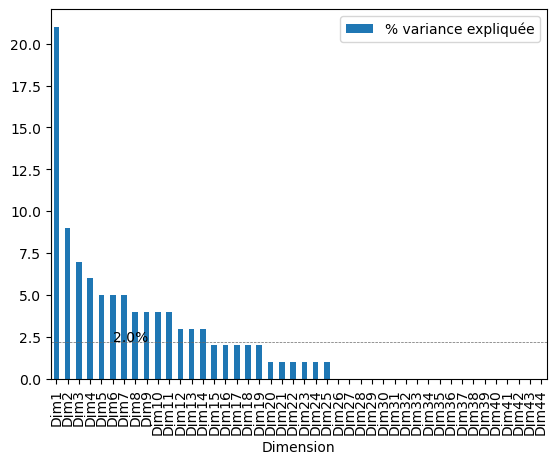

In [33]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 100/(len(pca.explained_variance_)+1), str(np.round(100/(len(pca.explained_variance_)+1)))+"%") # ajout de texte
plt.axhline(y = (100/(len(pca.explained_variance_)+1)), linewidth = .5, color = "dimgray", linestyle = "--") # (100/(len(pca.explained_variance_)+1)) (nb dimensions)
plt.show()


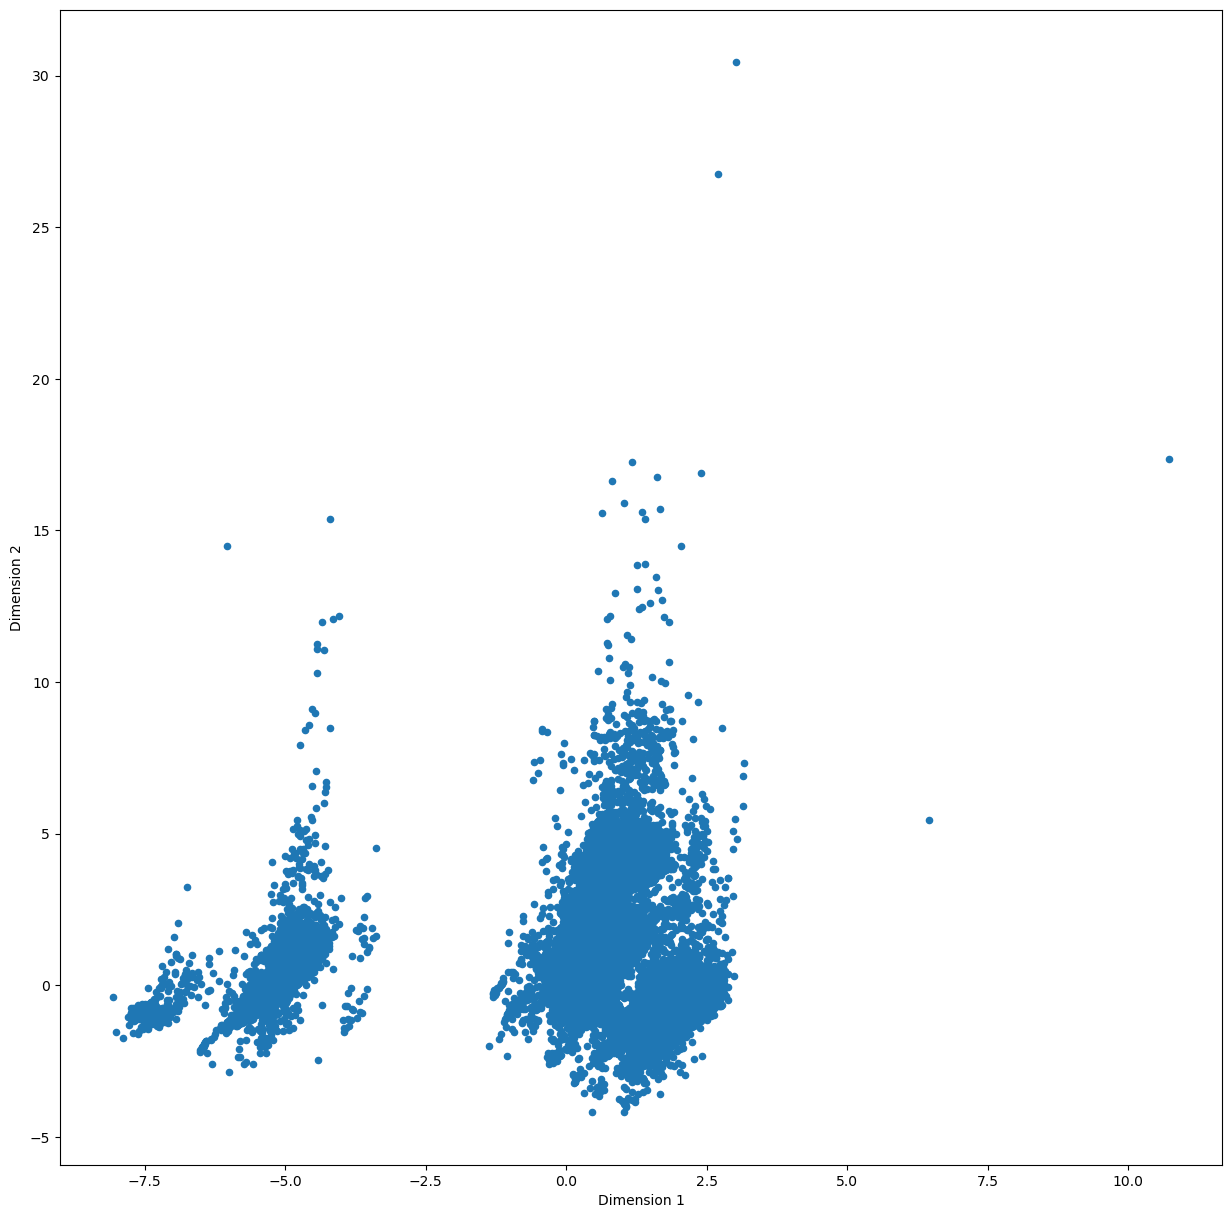

In [34]:
# Représentation de l'ACP :

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
# for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    # if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        # ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

<AxesSubplot: xlabel='Dim1', ylabel='Dim2'>

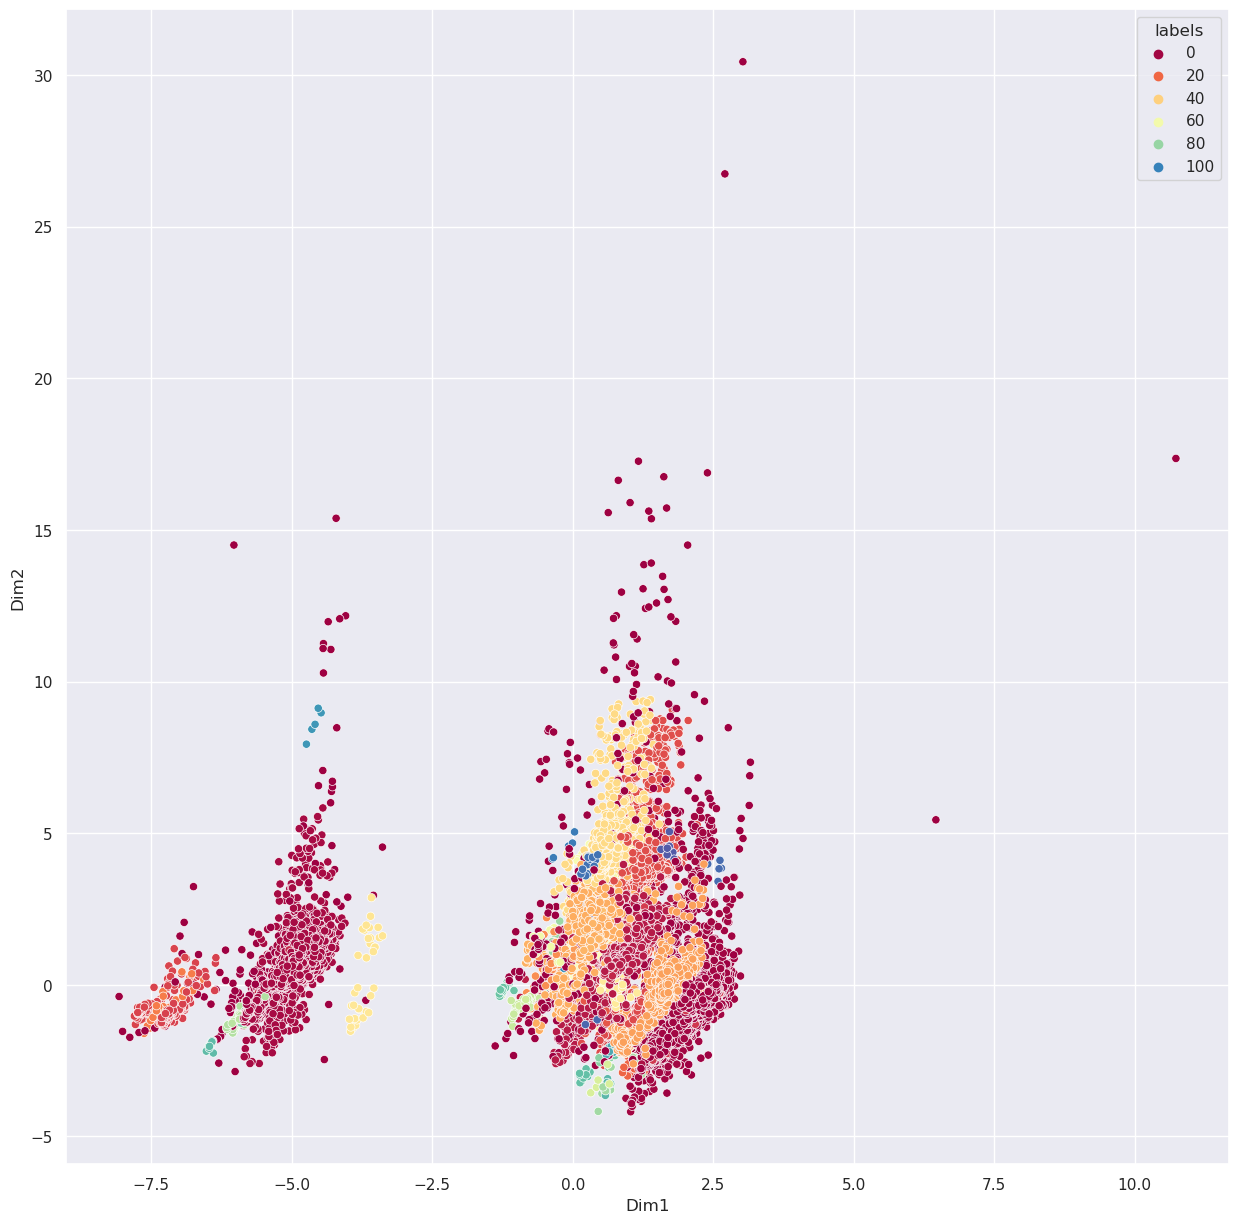

In [41]:
# Représentation de DBSCAN avec l'ACP : 
sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")

In [ ]:
# ACP en cascade :........................
#- ACP en cascade : sélectionner 10 familles de variables, faire une ACP sur chaque famille, 
# récupérer les axes, faire une 2e ACP sur toutes les ACP (pour enlever le problème des variables catégorielles)
# Sparse ACP ?

In [51]:
# UMAP : autre méthode de réduction de dimension :

reducer = umap.umap_.UMAP()
reduced_X = reducer.fit_transform(df_cct.values)

AttributeError: module 'umap' has no attribute 'umap_'

In [ ]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

In [ ]:
# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")